In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/EVA/session7/New_app

Mounted at /content/drive
/content/drive/My Drive/EVA/session7/New_app


In [2]:
!pwd

/content/drive/My Drive/EVA/session7/New_app


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import torch.nn.functional as F

In [4]:
from data_augmentation.albumenatiton import albumentations_transforms

In [5]:
from config import ModelConfig
args = ModelConfig()
args.print_config()

args

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.1,
  'max_lr': 0.01,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}


In [ ]:
from data_loader.data_pull_CIFAR10_new import data_pull_CIFAR10

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
from GradCAM.gradcam import GradCam
from utils.normalize import normalize,denormalize,imshow
from GradCAM.visualize import VisualizeCam
import matplotlib.pyplot as plt

## Import Dataset

Files already downloaded and verified
Files already downloaded and verified
 deer horse  deer  frog


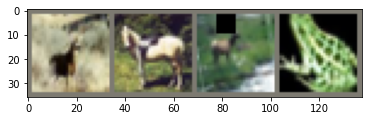

In [ ]:
data = data_pull_CIFAR10(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

In [ ]:
trainloader=data.train_loader
testloader=data.test_loader
classes=data.classes


In [ ]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

## Check Summary

In [ ]:
from utils.summary import get_summary
from model.ResNet18 import *

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model=ResNet18(args.dropout).to(device)

In [ ]:
get_summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Find best LR to train model

In [ ]:
from trainer import train_test_fit
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from learning_rate.lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()


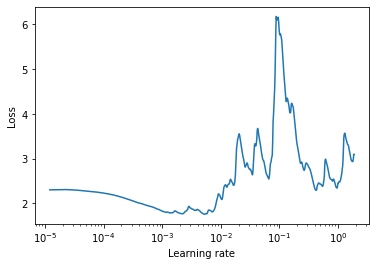

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data.train_loader, val_loader=testloader, start_lr=1e-5, end_lr=2,
                     num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [ ]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))
args.lr = best_lr

Best Loss: 1.762705367391614
Best Learning Rate: 0.005227609098797136


## Run the model on best Learning Rate

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                              verbose=True, min_lr=1e-5)

In [ ]:
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs  =train_test_fit.fit(model, device, trainloader,testloader,classes,criterion,optimizer,scheduler,epochs=50,l1_decay=0.0, l2_decay=0.0)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.8918094635009766 Batch_id=781 Accuracy=49.94: 100%|██████████| 782/782 [01:08<00:00, 11.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0162, Accuracy: 6337/10000 (63.37%)

EPOCH: 2


Loss=0.9239588975906372 Batch_id=781 Accuracy=68.64: 100%|██████████| 782/782 [01:08<00:00, 11.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0132, Accuracy: 7102/10000 (71.02%)

EPOCH: 3


Loss=1.0019123554229736 Batch_id=781 Accuracy=75.45: 100%|██████████| 782/782 [01:09<00:00, 11.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0099, Accuracy: 7836/10000 (78.36%)

EPOCH: 4


Loss=0.6850597262382507 Batch_id=781 Accuracy=79.29: 100%|██████████| 782/782 [01:09<00:00, 11.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0092, Accuracy: 7967/10000 (79.67%)

EPOCH: 5


Loss=0.702610194683075 Batch_id=781 Accuracy=82.17: 100%|██████████| 782/782 [01:09<00:00, 11.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0086, Accuracy: 8169/10000 (81.69%)

EPOCH: 6


Loss=0.29468655586242676 Batch_id=781 Accuracy=83.88: 100%|██████████| 782/782 [01:09<00:00, 11.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8402/10000 (84.02%)

EPOCH: 7


Loss=1.1411113739013672 Batch_id=781 Accuracy=85.66: 100%|██████████| 782/782 [01:09<00:00, 11.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8430/10000 (84.30%)

EPOCH: 8


Loss=0.5389976501464844 Batch_id=781 Accuracy=87.09: 100%|██████████| 782/782 [01:09<00:00, 11.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8522/10000 (85.22%)

EPOCH: 9


Loss=0.18410331010818481 Batch_id=781 Accuracy=88.23: 100%|██████████| 782/782 [01:09<00:00, 11.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0064, Accuracy: 8647/10000 (86.47%)

EPOCH: 10


Loss=0.06998187303543091 Batch_id=781 Accuracy=89.21: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8513/10000 (85.13%)

EPOCH: 11


Loss=0.2917848229408264 Batch_id=781 Accuracy=90.02: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0064, Accuracy: 8654/10000 (86.54%)

EPOCH: 12


Loss=0.22602403163909912 Batch_id=781 Accuracy=90.83: 100%|██████████| 782/782 [01:09<00:00, 11.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8551/10000 (85.51%)

EPOCH: 13


Loss=0.04002667963504791 Batch_id=781 Accuracy=91.62: 100%|██████████| 782/782 [01:09<00:00, 11.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0066, Accuracy: 8658/10000 (86.58%)

EPOCH: 14


Loss=0.16705121099948883 Batch_id=781 Accuracy=92.25: 100%|██████████| 782/782 [01:09<00:00, 11.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0063, Accuracy: 8696/10000 (86.96%)

EPOCH: 15


Loss=0.3008071780204773 Batch_id=781 Accuracy=92.37: 100%|██████████| 782/782 [01:08<00:00, 11.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0063, Accuracy: 8760/10000 (87.60%)

EPOCH: 16


Loss=0.05286562815308571 Batch_id=781 Accuracy=93.30: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 8835/10000 (88.35%)

EPOCH: 17


Loss=0.03880159556865692 Batch_id=781 Accuracy=93.78: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8644/10000 (86.44%)

EPOCH: 18


Loss=0.2162272185087204 Batch_id=781 Accuracy=94.28: 100%|██████████| 782/782 [01:08<00:00, 11.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0067, Accuracy: 8760/10000 (87.60%)

EPOCH: 19


Loss=0.3042619824409485 Batch_id=781 Accuracy=94.75: 100%|██████████| 782/782 [01:09<00:00, 11.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0067, Accuracy: 8793/10000 (87.93%)

EPOCH: 20


Loss=0.091920867562294 Batch_id=781 Accuracy=94.93: 100%|██████████| 782/782 [01:09<00:00, 11.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0062, Accuracy: 8835/10000 (88.35%)

Epoch    20: reducing learning rate of group 0 to 5.2276e-04.
EPOCH: 21


Loss=0.005253249779343605 Batch_id=781 Accuracy=96.79: 100%|██████████| 782/782 [01:09<00:00, 11.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 82 %
Accuracy of   cat : 72 %
Accuracy of  deer : 95 %
Accuracy of   dog : 88 %
Accuracy of  frog : 96 %
Accuracy of horse : 92 %
Accuracy of  ship : 91 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0052, Accuracy: 9023/10000 (90.23%)

EPOCH: 22


Loss=0.048691216856241226 Batch_id=781 Accuracy=97.65: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 94 %
Accuracy of  bird : 90 %
Accuracy of   cat : 78 %
Accuracy of  deer : 90 %
Accuracy of   dog : 85 %
Accuracy of  frog : 89 %
Accuracy of horse : 95 %
Accuracy of  ship : 90 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0052, Accuracy: 9032/10000 (90.32%)

EPOCH: 23


Loss=0.015008410438895226 Batch_id=781 Accuracy=97.93: 100%|██████████| 782/782 [01:08<00:00, 11.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 97 %
Accuracy of  bird : 85 %
Accuracy of   cat : 85 %
Accuracy of  deer : 93 %
Accuracy of   dog : 84 %
Accuracy of  frog : 89 %
Accuracy of horse : 94 %
Accuracy of  ship : 96 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0051, Accuracy: 9024/10000 (90.24%)

EPOCH: 24


Loss=0.045337434858083725 Batch_id=781 Accuracy=97.93: 100%|██████████| 782/782 [01:09<00:00, 11.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 92 %
Accuracy of  bird : 89 %
Accuracy of   cat : 82 %
Accuracy of  deer : 90 %
Accuracy of   dog : 85 %
Accuracy of  frog : 93 %
Accuracy of horse : 92 %
Accuracy of  ship : 92 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0051, Accuracy: 9050/10000 (90.50%)

EPOCH: 25


Loss=0.09243451058864594 Batch_id=781 Accuracy=98.19: 100%|██████████| 782/782 [01:09<00:00, 11.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 98 %
Accuracy of  bird : 93 %
Accuracy of   cat : 77 %
Accuracy of  deer : 88 %
Accuracy of   dog : 85 %
Accuracy of  frog : 96 %
Accuracy of horse : 98 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0052, Accuracy: 9033/10000 (90.33%)

EPOCH: 26


Loss=0.027963334694504738 Batch_id=781 Accuracy=98.30: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 92 %
Accuracy of  bird : 91 %
Accuracy of   cat : 72 %
Accuracy of  deer : 95 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 92 %
Accuracy of  ship : 91 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0052, Accuracy: 9041/10000 (90.41%)

EPOCH: 27


Loss=0.03424680605530739 Batch_id=781 Accuracy=98.30: 100%|██████████| 782/782 [01:08<00:00, 11.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 95 %
Accuracy of  bird : 92 %
Accuracy of   cat : 73 %
Accuracy of  deer : 91 %
Accuracy of   dog : 78 %
Accuracy of  frog : 93 %
Accuracy of horse : 93 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0052, Accuracy: 9051/10000 (90.51%)

Epoch    27: reducing learning rate of group 0 to 5.2276e-05.
EPOCH: 28


Loss=0.0028436309657990932 Batch_id=781 Accuracy=98.43: 100%|██████████| 782/782 [01:08<00:00, 11.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 94 %
Accuracy of  bird : 78 %
Accuracy of   cat : 72 %
Accuracy of  deer : 90 %
Accuracy of   dog : 85 %
Accuracy of  frog : 95 %
Accuracy of horse : 89 %
Accuracy of  ship : 90 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0051, Accuracy: 9059/10000 (90.59%)

EPOCH: 29


Loss=0.0033687439281493425 Batch_id=781 Accuracy=98.44: 100%|██████████| 782/782 [01:08<00:00, 11.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 96 %
Accuracy of  bird : 87 %
Accuracy of   cat : 84 %
Accuracy of  deer : 87 %
Accuracy of   dog : 84 %
Accuracy of  frog : 92 %
Accuracy of horse : 92 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0052, Accuracy: 9074/10000 (90.74%)

EPOCH: 30


Loss=0.11294490844011307 Batch_id=781 Accuracy=98.47: 100%|██████████| 782/782 [01:09<00:00, 11.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 93 %
Accuracy of  bird : 88 %
Accuracy of   cat : 74 %
Accuracy of  deer : 90 %
Accuracy of   dog : 84 %
Accuracy of  frog : 94 %
Accuracy of horse : 93 %
Accuracy of  ship : 96 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0051, Accuracy: 9051/10000 (90.51%)

EPOCH: 31


Loss=0.0022642684634774923 Batch_id=781 Accuracy=98.60: 100%|██████████| 782/782 [01:08<00:00, 11.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 98 %
Accuracy of  bird : 87 %
Accuracy of   cat : 81 %
Accuracy of  deer : 84 %
Accuracy of   dog : 91 %
Accuracy of  frog : 89 %
Accuracy of horse : 87 %
Accuracy of  ship : 94 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0051, Accuracy: 9054/10000 (90.54%)

EPOCH: 32


Loss=0.009434675797820091 Batch_id=781 Accuracy=98.59: 100%|██████████| 782/782 [01:08<00:00, 11.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 98 %
Accuracy of  bird : 85 %
Accuracy of   cat : 68 %
Accuracy of  deer : 85 %
Accuracy of   dog : 81 %
Accuracy of  frog : 93 %
Accuracy of horse : 94 %
Accuracy of  ship : 95 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0052, Accuracy: 9055/10000 (90.55%)

Epoch    32: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 33


Loss=0.0035223476588726044 Batch_id=781 Accuracy=98.52: 100%|██████████| 782/782 [01:09<00:00, 11.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 100 %
Accuracy of  bird : 86 %
Accuracy of   cat : 79 %
Accuracy of  deer : 91 %
Accuracy of   dog : 89 %
Accuracy of  frog : 93 %
Accuracy of horse : 95 %
Accuracy of  ship : 90 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0051, Accuracy: 9060/10000 (90.60%)

EPOCH: 34


Loss=0.12145990878343582 Batch_id=781 Accuracy=98.51: 100%|██████████| 782/782 [01:09<00:00, 11.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 100 %
Accuracy of  bird : 86 %
Accuracy of   cat : 78 %
Accuracy of  deer : 91 %
Accuracy of   dog : 87 %
Accuracy of  frog : 90 %
Accuracy of horse : 90 %
Accuracy of  ship : 92 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0051, Accuracy: 9073/10000 (90.73%)

EPOCH: 35


Loss=0.007379460614174604 Batch_id=781 Accuracy=98.53: 100%|██████████| 782/782 [01:09<00:00, 11.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 95 %
Accuracy of  bird : 88 %
Accuracy of   cat : 76 %
Accuracy of  deer : 90 %
Accuracy of   dog : 83 %
Accuracy of  frog : 95 %
Accuracy of horse : 87 %
Accuracy of  ship : 88 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0052, Accuracy: 9057/10000 (90.57%)

EPOCH: 36


Loss=0.013477610424160957 Batch_id=781 Accuracy=98.53: 100%|██████████| 782/782 [01:08<00:00, 11.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 95 %
Accuracy of  bird : 91 %
Accuracy of   cat : 77 %
Accuracy of  deer : 86 %
Accuracy of   dog : 85 %
Accuracy of  frog : 97 %
Accuracy of horse : 85 %
Accuracy of  ship : 92 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0051, Accuracy: 9059/10000 (90.59%)

EPOCH: 37


Loss=0.03364991396665573 Batch_id=781 Accuracy=98.49: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 96 %
Accuracy of  bird : 78 %
Accuracy of   cat : 87 %
Accuracy of  deer : 93 %
Accuracy of   dog : 84 %
Accuracy of  frog : 96 %
Accuracy of horse : 89 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0051, Accuracy: 9056/10000 (90.56%)

EPOCH: 38


Loss=0.008199593052268028 Batch_id=781 Accuracy=98.53: 100%|██████████| 782/782 [01:08<00:00, 11.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 98 %
Accuracy of  bird : 76 %
Accuracy of   cat : 71 %
Accuracy of  deer : 88 %
Accuracy of   dog : 88 %
Accuracy of  frog : 95 %
Accuracy of horse : 91 %
Accuracy of  ship : 92 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0051, Accuracy: 9064/10000 (90.64%)

EPOCH: 39


Loss=0.0828234851360321 Batch_id=781 Accuracy=98.47: 100%|██████████| 782/782 [01:08<00:00, 11.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 97 %
Accuracy of  bird : 85 %
Accuracy of   cat : 90 %
Accuracy of  deer : 91 %
Accuracy of   dog : 80 %
Accuracy of  frog : 96 %
Accuracy of horse : 94 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0052, Accuracy: 9059/10000 (90.59%)

EPOCH: 40


Loss=0.35197192430496216 Batch_id=781 Accuracy=98.50: 100%|██████████| 782/782 [01:09<00:00, 11.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 98 %
Accuracy of  bird : 83 %
Accuracy of   cat : 83 %
Accuracy of  deer : 89 %
Accuracy of   dog : 87 %
Accuracy of  frog : 98 %
Accuracy of horse : 88 %
Accuracy of  ship : 93 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0052, Accuracy: 9066/10000 (90.66%)

EPOCH: 41


Loss=0.015351579524576664 Batch_id=781 Accuracy=98.61: 100%|██████████| 782/782 [01:09<00:00, 11.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 91 %
Accuracy of   cat : 71 %
Accuracy of  deer : 89 %
Accuracy of   dog : 73 %
Accuracy of  frog : 90 %
Accuracy of horse : 98 %
Accuracy of  ship : 88 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0052, Accuracy: 9070/10000 (90.70%)

EPOCH: 42


Loss=0.13921277225017548 Batch_id=781 Accuracy=98.56: 100%|██████████| 782/782 [01:08<00:00, 11.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 95 %
Accuracy of  bird : 91 %
Accuracy of   cat : 83 %
Accuracy of  deer : 86 %
Accuracy of   dog : 79 %
Accuracy of  frog : 87 %
Accuracy of horse : 92 %
Accuracy of  ship : 96 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0052, Accuracy: 9061/10000 (90.61%)

EPOCH: 43


Loss=0.02339901775121689 Batch_id=781 Accuracy=98.51: 100%|██████████| 782/782 [01:09<00:00, 11.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 98 %
Accuracy of  bird : 81 %
Accuracy of   cat : 73 %
Accuracy of  deer : 96 %
Accuracy of   dog : 74 %
Accuracy of  frog : 93 %
Accuracy of horse : 90 %
Accuracy of  ship : 90 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0051, Accuracy: 9067/10000 (90.67%)

EPOCH: 44


Loss=0.023415248841047287 Batch_id=781 Accuracy=98.67: 100%|██████████| 782/782 [01:09<00:00, 11.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 97 %
Accuracy of  bird : 93 %
Accuracy of   cat : 72 %
Accuracy of  deer : 85 %
Accuracy of   dog : 72 %
Accuracy of  frog : 100 %
Accuracy of horse : 92 %
Accuracy of  ship : 94 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0051, Accuracy: 9050/10000 (90.50%)

EPOCH: 45


Loss=0.04418295994400978 Batch_id=781 Accuracy=98.46: 100%|██████████| 782/782 [01:09<00:00, 11.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 98 %
Accuracy of   car : 94 %
Accuracy of  bird : 88 %
Accuracy of   cat : 78 %
Accuracy of  deer : 95 %
Accuracy of   dog : 81 %
Accuracy of  frog : 91 %
Accuracy of horse : 90 %
Accuracy of  ship : 95 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0052, Accuracy: 9050/10000 (90.50%)

EPOCH: 46


Loss=0.13617166876792908 Batch_id=781 Accuracy=98.58: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 94 %
Accuracy of  bird : 92 %
Accuracy of   cat : 80 %
Accuracy of  deer : 89 %
Accuracy of   dog : 87 %
Accuracy of  frog : 95 %
Accuracy of horse : 94 %
Accuracy of  ship : 93 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0051, Accuracy: 9055/10000 (90.55%)

EPOCH: 47


Loss=0.011169666424393654 Batch_id=781 Accuracy=98.63: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 93 %
Accuracy of  bird : 90 %
Accuracy of   cat : 80 %
Accuracy of  deer : 96 %
Accuracy of   dog : 85 %
Accuracy of  frog : 94 %
Accuracy of horse : 92 %
Accuracy of  ship : 97 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0051, Accuracy: 9064/10000 (90.64%)

EPOCH: 48


Loss=0.006052389740943909 Batch_id=781 Accuracy=98.56: 100%|██████████| 782/782 [01:09<00:00, 11.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 87 %
Accuracy of   cat : 84 %
Accuracy of  deer : 92 %
Accuracy of   dog : 84 %
Accuracy of  frog : 89 %
Accuracy of horse : 91 %
Accuracy of  ship : 92 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0051, Accuracy: 9057/10000 (90.57%)

EPOCH: 49


Loss=0.015069639310240746 Batch_id=781 Accuracy=98.60: 100%|██████████| 782/782 [01:08<00:00, 11.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 90 %
Accuracy of  bird : 89 %
Accuracy of   cat : 86 %
Accuracy of  deer : 96 %
Accuracy of   dog : 81 %
Accuracy of  frog : 89 %
Accuracy of horse : 97 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0051, Accuracy: 9068/10000 (90.68%)

EPOCH: 50


Loss=0.009471986442804337 Batch_id=781 Accuracy=98.56: 100%|██████████| 782/782 [01:08<00:00, 11.34it/s]
/content/drive/My Drive/EVA/session7/New_app/trainer/train_test_fit.py:87: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  misclassified_inds = (is_correct == 0).nonzero()[:, 0]



Accuracy of plane : 96 %
Accuracy of   car : 96 %
Accuracy of  bird : 87 %
Accuracy of   cat : 75 %
Accuracy of  deer : 85 %
Accuracy of   dog : 84 %
Accuracy of  frog : 90 %
Accuracy of horse : 94 %
Accuracy of  ship : 85 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0051, Accuracy: 9064/10000 (90.64%)



### Best Training Accuracy - 98.67%
### Best Test Accuracy - 90.74%


#Plots

In [ ]:
from GradCAM.gradcam import GradCam
from utils.normalize import *
from GradCAM.visualize import VisualizeCam

In [ ]:
from utils.plots import plot_graph,plot_images

## Test Loss Curve

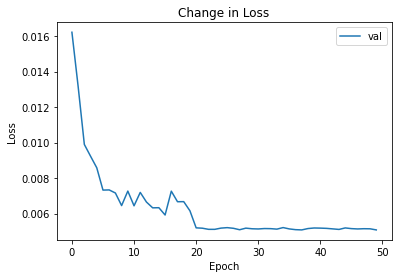

In [ ]:
#plot_graph(test_losses, "Loss")
plt_data = {"val": test_losses}
plot_graph(plt_data, "Loss")

## Train Accuracy Curve

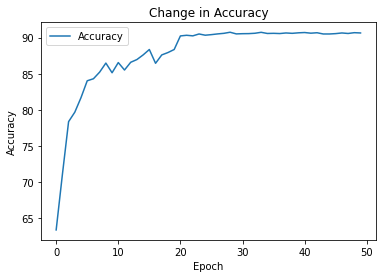

In [ ]:
#plot_graph(test_accs, "Accuracy")
plt_data = {"Accuracy": test_accs}
plot_graph(plt_data, "Accuracy")

## Train and Test Accuracy Curve

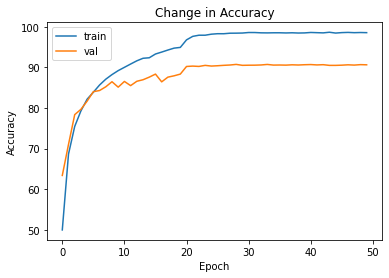

In [ ]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

## Correctly Classified images

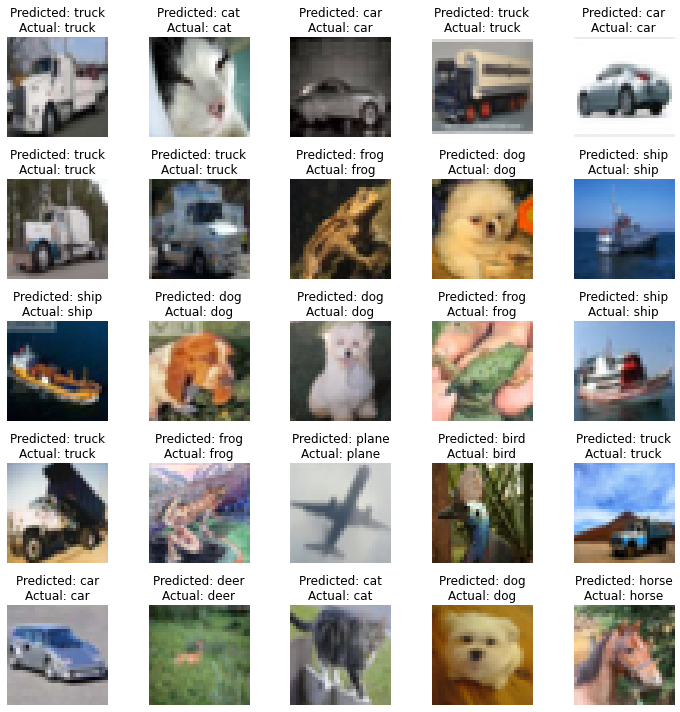

In [ ]:
plot_images(correct_imgs, classes, "correct_imgs.png")

## Mis-Classified images

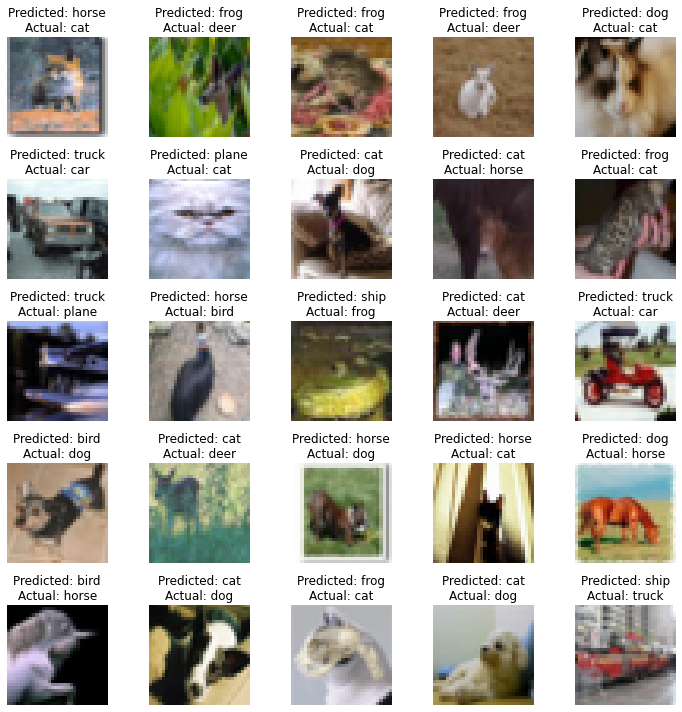

In [ ]:
plot_images(misclassified_imgs, classes, "misclassified_imgs1.png")

## GradCAM for correctly classified images

In [ ]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,classes, target_layers)

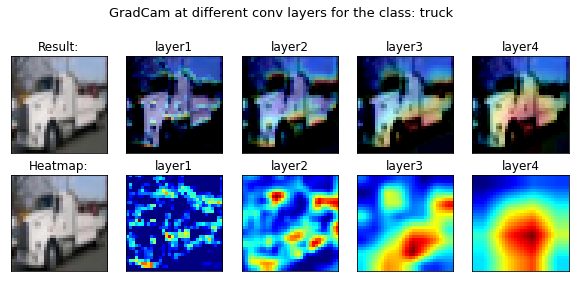

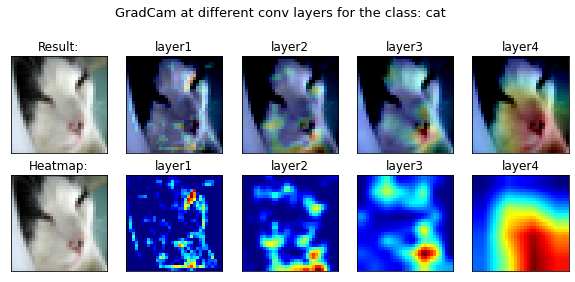

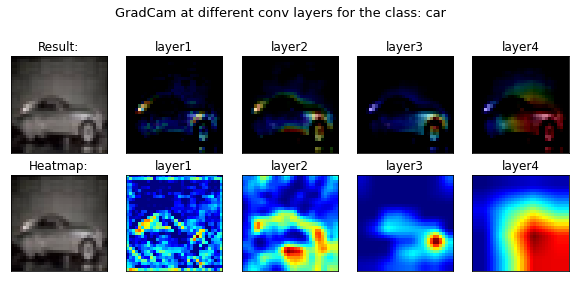

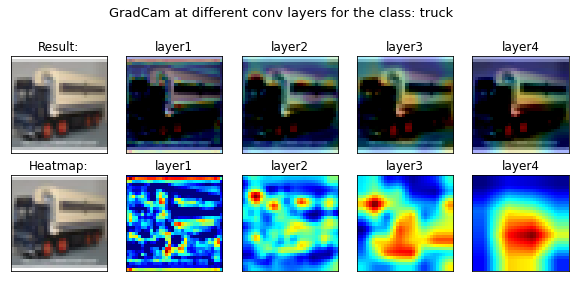

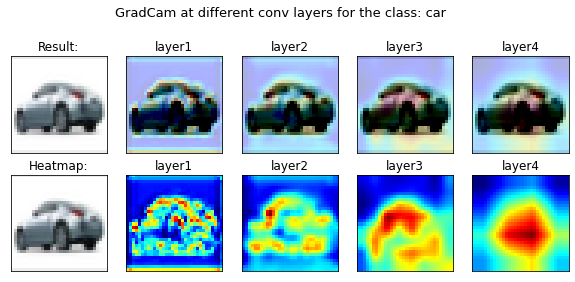

In [ ]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

## GradCAM for misclassified images

In [ ]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

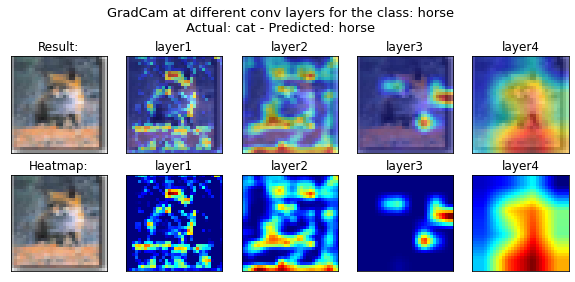

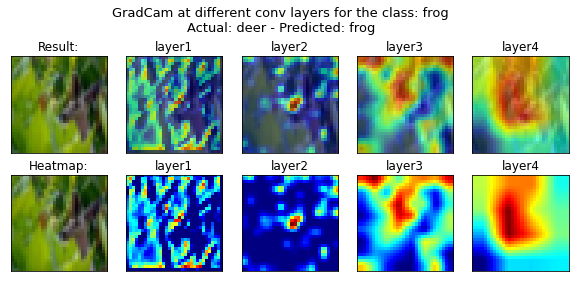

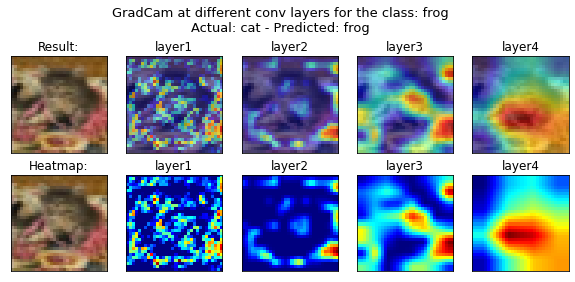

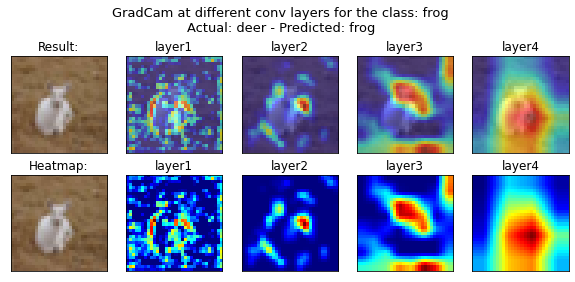

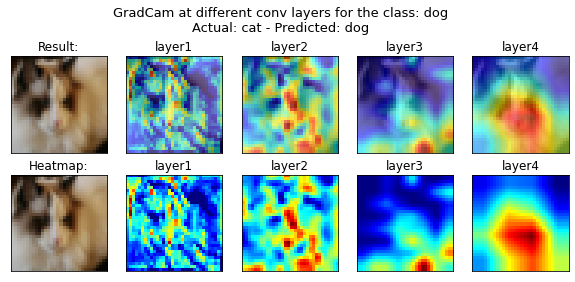

In [ ]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")


## 25 Mis-Classified images

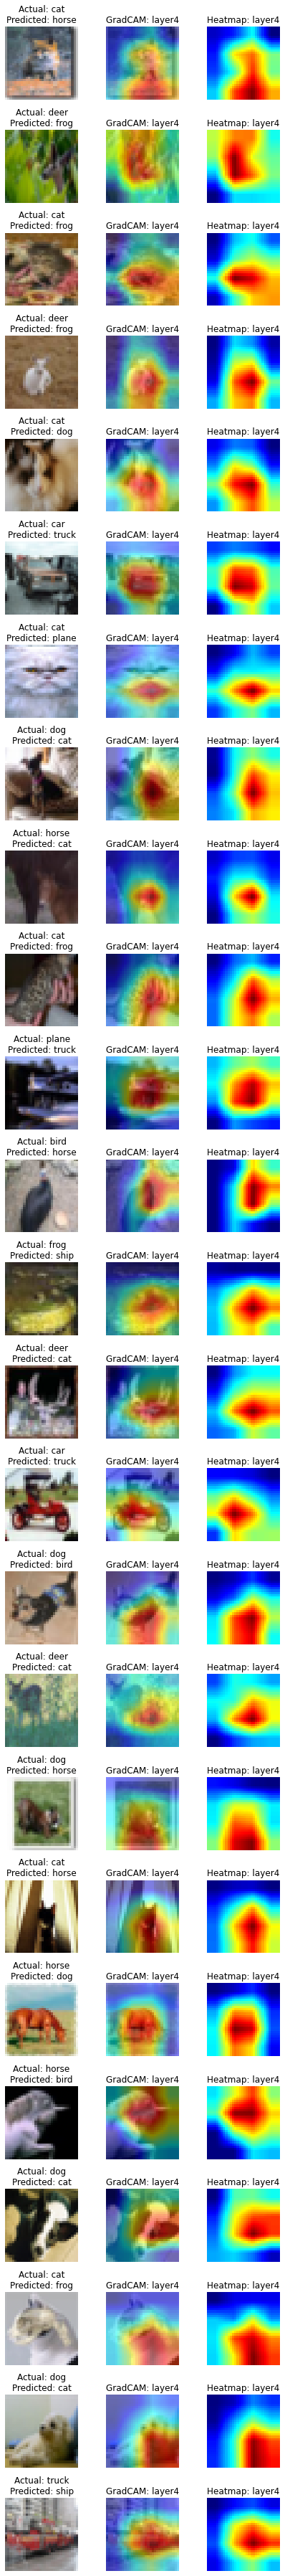

In [ ]:
num_img = 25
misclassified_imgs2 = []
truth_inds = []
for i in range(num_img):
  misclassified_imgs2.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(misclassified_imgs2), truth_inds, target_layers, metric="incorrect", per_image=False)